## Importing necessary libraries

In [2]:
# standard library
from typing import List

# data wrangling
import numpy as np
import pandas as pd

# visualisation
import plotly.express as px
import plotly.io as pio

# nlp
import spacy

# data modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# utils
from tqdm import tqdm

# local packages
from helpers import plot_confusion_matrix, get_top_features, fix_sdg_name

print('Loaded!')

Loaded!


#### Here we are using Spacy for removing unnecessary words such as stopping words which doesn't provide any meaning and disabling ner(named entity recognition).

In [3]:
# other settings
pio.templates.default = 'plotly_dark'
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable = ['ner'])


## Loading data and exploring

In [4]:
dataset = pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')
print('Shape:', dataset.shape)
#display(dataset['text'].values)
#display(dataset.head())

Shape: (32121, 7)


In [5]:
# calculating cumulative probability over agreement scores
df_lambda = dataset['agreement'].value_counts(normalize = True).sort_index().cumsum().to_frame(name = 'p_sum')
df_lambda.reset_index(inplace = True)
df_lambda.rename({'index': 'agreement'}, axis = 1, inplace = True)

print('Shape:', df_lambda.shape)


Shape: (36, 2)


In [6]:
# keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least .6
print('Shape before:', dataset.shape)
dataset = dataset.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', dataset.shape)


Shape before: (32121, 7)
Shape after : (17233, 7)


In [7]:
df3 = dataset['sdg'].value_counts()
df3.columns = ['sdg', 'count']
print (df3.sort_index())

1     1146
2      827
3     1854
4     2324
5     2286
6     1343
7     1589
8      859
9      688
10     437
11    1260
12     244
13    1129
14     705
15     542
Name: sdg, dtype: int64


In [8]:
df_lambda = dataset.groupby('sdg', as_index = False).agg(count = ('text_id', 'count'))
df_lambda['share'] = df_lambda['count'].divide(df_lambda['count'].sum()).multiply(100)
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (15, 3)


,sdg,count,share
0,1,1146,6.650032
1,2,827,4.798932
2,3,1854,10.758429
3,4,2324,13.485754
4,5,2286,13.265247


## Preprocess_spacy function which takes text from the dataframe and returns meaningful words

In [9]:
def preprocess_spacy(alpha: List[str]) -> List[str]:
   
    docs = list()
    
    for doc in tqdm(nlp.pipe(alpha, batch_size = 128)):
        tokens = list()
        for token in doc:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
                tokens.append(token.lemma_)
        docs.append(' '.join(tokens))
    
    return docs
  

### Calling the preprocess_spacy function 

In [10]:
dataset['docs'] = preprocess_spacy(dataset['text'].values)
print('\nShape:', dataset.shape)
display(dataset.head())

17233it [01:13, 234.82it/s]


Shape: (17233, 8)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement,docs
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000,gender perspective point labour market fishing...
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286,average figure mask large difference region nu...
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000,station monitor quantity quality water coastli...
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000,previous chapter discuss way make food system ...
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000,prescription rate appear high labour force par...


## Splitting the dataset into training and testing data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset['docs'].values, 
    dataset['sdg'].values, 
    test_size = .3,
    random_state = 42
)

## Multi Classification starts here ! ! ! !
### I am using ExtraTreesClassifier for multi-classification


In [12]:
from sklearn.ensemble import ExtraTreesClassifier
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000)),
    ('clf',ExtraTreesClassifier())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf', ExtraTreesClassifier())])

## Getting Model Accuracy

In [13]:
y_hat = pipe.predict(X_test)
from sklearn.metrics import accuracy_score
model_accuracy = accuracy_score(y_test, y_hat)
print('Accuracy of the Model = ', int(model_accuracy*100),'%')

Accuracy of the Model =  84 %


## Confusion Matrix

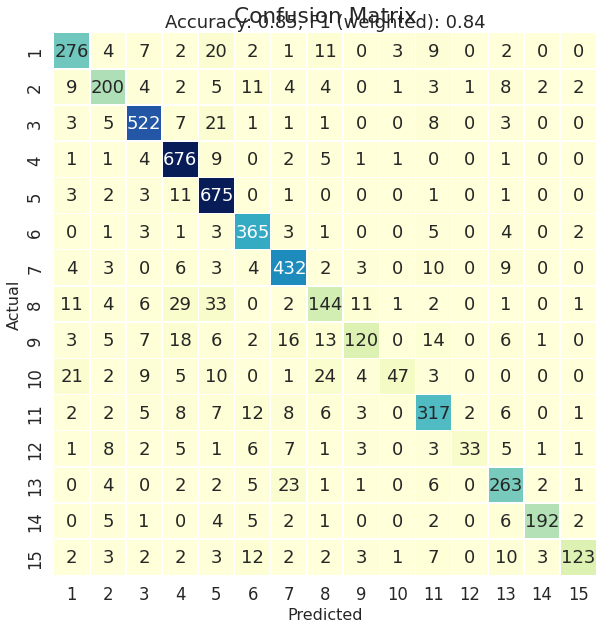

In [14]:
plot_confusion_matrix(y_test, y_hat)

## Predicting the goal and respective probabilities for training dataset.

In [15]:
# Here I took 3rd text in the text column of dataset and predicted the SDG goal number.
predicted_goal= pipe.predict([X_test[3]])
print(predicted_goal)

[5]


In [16]:
# Predicting the probability of each and every goal.
predicted_probabilities = pipe.predict_proba([X_test[3]])
print(predicted_probabilities)

[[0.11 0.01 0.03 0.   0.7  0.01 0.01 0.05 0.02 0.   0.   0.   0.   0.01
  0.05]]


### Classification report of the model

In [17]:
print(classification_report(y_test, y_hat, zero_division = 0))

              precision    recall  f1-score   support

           1       0.82      0.82      0.82       337
           2       0.80      0.78      0.79       256
           3       0.91      0.91      0.91       572
           4       0.87      0.96      0.92       701
           5       0.84      0.97      0.90       697
           6       0.86      0.94      0.90       388
           7       0.86      0.91      0.88       476
           8       0.67      0.59      0.62       245
           9       0.81      0.57      0.67       211
          10       0.87      0.37      0.52       126
          11       0.81      0.84      0.82       379
          12       0.92      0.43      0.58        77
          13       0.81      0.85      0.83       310
          14       0.96      0.87      0.91       220
          15       0.92      0.70      0.80       175

    accuracy                           0.85      5170
   macro avg       0.85      0.77      0.79      5170
weighted avg       0.85   

In [18]:
!pip install pdfminer

     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 2.0 MB 35.6 MB/s 
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140092 sha256=ada77b3d2d4790520bdd063de8b641bfbfcbc761b92c1ab9e836df6b353d8ef0
  Stored in directory: /root/.cache/pip/wheels/e3/5e/f4/d210b46e9e4a28229ea070ed5b3efa92c3c29d1a7918dd4b97
Successfully built pdfminer


## Uploading PDF and converting to text 

In [19]:
!pip install pdfminer

In [20]:
#Importing required libraries

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import nltk
import os
import re
import pickle
from datetime import datetime

# convert_pdf_to_text is the function which takes pdf file and converts it into text and returns text.

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text


## Uploading PDF to google colab

In [21]:
from google.colab import files
uploaded = files.upload()


Saving Water goal.pdf to Water goal.pdf


In [22]:
# Getting the uploaded file name 
var = (*uploaded,)
str2= var[0]
str2

'Water goal.pdf'

In [23]:
# Creating path of the uploaded file
str1 = "/content/"
Final_path = str1+str2
Final_path

'/content/Water goal.pdf'

In [24]:
#Giving final path to the text
text = convert_pdf_to_txt(Final_path)


In [25]:
# Creating a new dataframe for giving text to preprocessspacy function.
# Because it take the values of the column as input.
# So created a dataframe and inserting txt into particular column called "docs" in the dataframe

Final_df  = pd.DataFrame()
Final_df['text'] = [text]

In [26]:
# Giving the text which is in the dataframe to preprocess_spacy function

Final_df['docs'] = preprocess_spacy(Final_df['text'].values)

1it [00:01,  1.08s/it]


In [27]:
#Predicting the Final goal of a pdf

Final_predicted_goal = pipe.predict(Final_df['docs'])
print("SDG Goal : ",Final_predicted_goal)

SDG Goal :  [6]


In [28]:
# Predicting the probabilities of every goal according to uploaded pdf.

Final_predicted_probabilities = pipe.predict_proba(Final_df['docs']).flatten()
print("Probabilities of each goal in order :",Final_predicted_probabilities)

Probabilities of each goal in order : [0.07 0.05 0.05 0.12 0.11 0.15 0.15 0.05 0.02 0.03 0.05 0.03 0.09 0.03
 0.  ]


## Printing a final dataframe with "Goal_Numbers" and "Goal_Probabilities"!!!!

In [29]:
goals_data= {'SDG Goals':['No Poverty', 'Zero Hunger', 'Good Health and Well-Being',
                             'Quality Education', 'Gender Equality', 'Clean Water And Sanitation', 
                             'Affordable Clean Energy','Decent Work And Economic Growth',
                             'Industry,Innovation And Infrastructure', 'Reduced Inqualities',
                             'Sustainable Cities And Communities', 'Responsible Consumption And Production',
                             'Climate Action', 'Life Below Earth', 'Life on Land'],
             'Goal_Number':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
df1  = pd.DataFrame(goals_data)
Prob= pipe.predict_proba(Final_df['docs']).flatten() # Probabilities of each goals
df1['Probability_Scores']= Prob
Final_Table = df1.sort_values(["Probability_Scores"], ascending=False) # Sorting the goals based on highest probabilities
print(Final_Table) #Printing the final table

                                 SDG Goals  Goal_Number  Probability_Scores
5               Clean Water And Sanitation            6                0.15
6                  Affordable Clean Energy            7                0.15
3                        Quality Education            4                0.12
4                          Gender Equality            5                0.11
12                          Climate Action           13                0.09
0                               No Poverty            1                0.07
1                              Zero Hunger            2                0.05
2               Good Health and Well-Being            3                0.05
7          Decent Work And Economic Growth            8                0.05
10      Sustainable Cities And Communities           11                0.05
9                      Reduced Inqualities           10                0.03
11  Responsible Consumption And Production           12                0.03
13          